# Text Generation

### Import Libs

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Optional, Sequence
from random import sample
from IPython.display import clear_output

import torch
import torch.nn.functional as F
from torch import nn

### Options

In [2]:
! nvidia-smi

Thu Jan  5 22:37:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:06.0 Off |                    0 |
| N/A   28C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
torch.cuda.is_available()

True

## 1. Generating names with RNN

### Data

In [4]:
START_TOKEN, PAD_TOKEN = "_", " "

In [5]:
def read_names(filename: str, start_token: str = START_TOKEN):
    with open(filename) as file:
        return [start_token + line.strip() for line in file]

In [6]:
names = read_names("./data/names.txt")

In [7]:
print(f"n samples = {len(names)}\n")

for name in names[::1000]:
    print(name)

n samples = 7944

_Abagael
_Claresta
_Glory
_Liliane
_Prissie
_Geeta
_Giovanne
_Piggy


Max length = 16


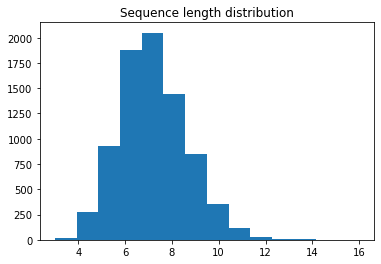

In [8]:
lengths = list(map(len, names))
MAX_LENGTH = max(lengths)
print(f"Max length = {MAX_LENGTH}")

plt.title("Sequence length distribution")
plt.hist(lengths, bins=14)
plt.show()

### Text Processing

In [9]:
tokens_set = set()

for name in names:
    tokens_set.update(name)

tokens = sorted(tokens_set)  # list of all unique characters in the dataset

num_tokens = len(tokens)
print(f"num_tokens = {num_tokens}")

num_tokens = 56


In [10]:
# dictionary of symbol -> its identifier (index in tokens list)
token_to_id = {token: idx for idx, token in enumerate(tokens)}

In [11]:
def to_matrix(
    names: Sequence[str],
    max_len: Optional[int] = None,
    pad: int = token_to_id[PAD_TOKEN],
    dtype=np.int64,
    batch_first: bool = True,
):
    """Casts a list of names into rnn-digestable matrix"""
    max_len = max_len or max(map(len, names))
    names_ix = np.full((len(names), max_len), pad, dtype)

    for i, name in enumerate(names):
        line_ix = [token_to_id[char] for char in name]
        names_ix[i, : len(line_ix)] = line_ix

    if not batch_first:  # convert [batch, time] into [time, batch]
        names_ix = np.transpose(names_ix)

    return names_ix

In [12]:
names[:2]

['_Abagael', '_Abagail']

In [13]:
# Example: cast 4 random names to matrices, pad with zeros
print("\n".join(names[::2000]))
print(to_matrix(names[::2000]))

_Abagael
_Glory
_Prissie
_Giovanne
[[29  3 31 30 36 30 34 41  0]
 [29  9 41 44 47 54  0  0  0]
 [29 18 47 38 48 48 38 34  0]
 [29  9 38 44 51 30 43 43 34]]


In [14]:
to_matrix(names).shape

(7944, 16)

### Recurrent neural network

In [15]:
emb_test = nn.Embedding(num_tokens, 7)  # One hot + Linears

In [16]:
emb_test

Embedding(56, 7)

In [17]:
example_batch = torch.from_numpy(to_matrix([" Den", " Jhon"])).type(torch.int64)

In [18]:
example_batch

tensor([[ 0,  6, 34, 43,  0],
        [ 0, 12, 37, 44, 43]])

In [19]:
emb = emb_test(example_batch)
emb.shape

torch.Size([2, 5, 7])

In [20]:
emb

tensor([[[ 2.2653, -0.8547,  0.7699,  0.4133, -0.5507, -2.1342, -1.7533],
         [ 0.9151,  1.0688, -0.5101, -1.0273,  0.6815,  1.8753,  0.4990],
         [ 0.6312,  0.5296,  0.2216, -0.5862, -1.2952,  0.1361,  1.0649],
         [-1.1370, -1.6315,  0.8531,  1.0994, -0.7462,  1.5261, -0.4912],
         [ 2.2653, -0.8547,  0.7699,  0.4133, -0.5507, -2.1342, -1.7533]],

        [[ 2.2653, -0.8547,  0.7699,  0.4133, -0.5507, -2.1342, -1.7533],
         [ 1.0078, -0.2039,  0.0453,  1.5313, -0.6939,  0.5984,  0.6693],
         [-0.9072,  0.0827, -1.5485,  0.3359, -1.1229,  1.6488,  0.4919],
         [-0.2259, -0.6530,  0.8102, -1.2330, -0.8840, -1.0996,  0.4064],
         [-1.1370, -1.6315,  0.8531,  1.0994, -0.7462,  1.5261, -0.4912]]],
       grad_fn=<EmbeddingBackward0>)

In [21]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """

    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units

        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.

        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        # batch, seq leng, emb dim
        x_emb = self.embedding(x)

        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        x_and_h = torch.cat([x_emb, h_prev], dim=-1)
        h_next = self.rnn_update(x_and_h)

        h_next = torch.tanh(h_next)

        # compute logits for next character probs
        logits = self.rnn_to_logits(h_next)

        return h_next, logits

    def initial_state(self, batch_size):
        """return rnn state before it processes first input (aka h0)"""
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [22]:
char_rnn = CharRNNCell()
criterion = nn.NLLLoss()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

In [23]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0, 1):
        hid_state, logits = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(F.log_softmax(logits, -1))

    return torch.stack(logprobs, dim=1)

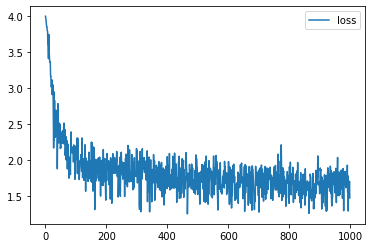

In [24]:
for i in range(1000):
    opt.zero_grad()

    batch_ix = to_matrix(sample(names, 32))
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

    logp_seq = rnn_loop(char_rnn, batch_ix)

    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    #     print(predictions_logp.shape, actual_next_tokens.shape)
    loss = criterion(
        predictions_logp.contiguous().view(-1, num_tokens),
        actual_next_tokens.contiguous().view(-1),
    )

    # train with backprop
    loss.backward()
    opt.step()

    history.append(loss.item())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label="loss")
        plt.legend()
        plt.show()

In [25]:
def generate_sample(char_rnn, seed_phrase=START_TOKEN, max_length=MAX_LENGTH, temperature=1.0):
    """
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    """

    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)

    # feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)

    # start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logits = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logits / temperature, dim=-1).data.numpy()[0]

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return "".join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [26]:
for _ in range(10):
    print(generate_sample(char_rnn, seed_phrase="_", temperature=1.0))

_Wielle         
_Mingy          
_Eleins         
_Tenkin         
_Cmatherne      
_Bannily        
_Chartibe       
_Lerter         
_Moiia          
_Arlein         


In [27]:
for _ in range(20):
    print(generate_sample(char_rnn, seed_phrase="_Al"))

_Almie          
_Alfind         
_Allise         
_Alvin          
_Alotel         
_Alis           
_Alarich        
_Alari          
_Alarla         
_Alelu          
_Alask          
_Alskaq         
_AloinZa        
_Alwerre        
_Alttin         
_Alftis         
_Allun          
_Ald            
_AlKie          
_Alle-bhil      


In [28]:
for _ in range(10):
    print(generate_sample(char_rnn, temperature=0.1))

_Dinne          
_Darista        
_Barista        
_Derie          
_Derina         
_Deris          
_Alina          
_Joris          
_Marrin         
_Aline          


In [29]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        self.num_units = rnn_num_units

    def forward(self, x):
        h_seq, _ = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp

    def forward_char(self, x, h=None):
        if h is None:
            out, h = self.rnn(self.emb(x))
        else:
            out, h = self.rnn(self.emb(x), h)
        out = self.hid_to_logits(out)
        return out, h

    def initial_state(self, batch_size):
        """return rnn state before it processes first input (aka h0)"""
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [30]:
model = CharRNNLoop()
opt = torch.optim.Adam(model.parameters())
history = []

# the model applies over the whole sequence
batch_ix = to_matrix(sample(names, 32), max_len=MAX_LENGTH)
batch_ix = torch.LongTensor(batch_ix)

In [31]:
logp_seq = model(batch_ix)

loss = criterion(
    logp_seq[:, :-1].contiguous().view(-1, num_tokens), batch_ix[:, 1:].contiguous().view(-1)
)

loss.backward()

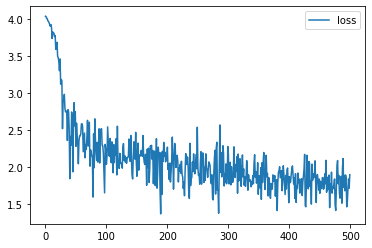

In [32]:
for i in range(500):
    opt.zero_grad()

    batch_ix = to_matrix(sample(names, 32))
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

    logp_seq = model(batch_ix)

    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = criterion(
        predictions_logp.contiguous().view(-1, num_tokens), actual_next_tokens.contiguous().view(-1)
    )

    # train with backprop
    loss.backward()
    opt.step()

    history.append(loss.data.numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label="loss")
        plt.legend()
        plt.show()

In [33]:
def generate_sample_lstm(
    char_rnn, seed_phrase=START_TOKEN, max_length=MAX_LENGTH, temperature=1.0, device=None
):
    """
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    """

    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)

    # feed the seed phrase, if any
    logits, h = char_rnn.forward_char(x_sequence)
    logits = logits[:, -1]

    # start generating
    for _ in range(max_length - x_sequence.shape[1] + 1):
        p_next = F.softmax(logits / temperature, dim=-1).cpu().data.numpy().squeeze()

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).to(device)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        logits, h = char_rnn.forward_char(next_ix, h)

    return "".join([tokens[ix] for ix in x_sequence.cpu().data.numpy()[0]])

In [34]:
for _ in range(10):
    print(generate_sample_lstm(model, temperature=1.0))

_Sobtregnen      
_Lrho            
_Dsrn            
_Nedriol s       
_Dgely           
_D eare          
_JAlye           
_Nerbggle        
_IhWamaro        
_Sinny           


## 2. Generating poetry with RNN